In [ ]:
#匯入套件與設定環境
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import scipy.io as sio
import os
import shutil
from PIL import Image
from google.colab import files

In [ ]:
#調整大小
def resize_image(image, size = (2048, 1536)):

  width, height = image.size
  aspect_ratio = 4 / 3

  #計算4:3的裁剪範圍
  if width / height > aspect_ratio:
    #圖片太寬，以高度為基準計算新寬度
    new_width = int(height * aspect_ratio)
    new_height = height
  else:
    #圖片太高，以寬度為基準計算新高度
    new_width = width
    new_height = int(width / aspect_ratio)

  #計算裁剪的範圍（從中心開始）
  left = (width - new_width) // 2
  top = (height - new_height) // 2
  right = left + new_width
  bottom = top + new_height

  #裁剪4:3區域
  img_cropped = image.crop((left, top, right, bottom))

  #調整大小
  img_resized = img_cropped.resize(size, Image.LANCZOS)

  return img_resized

In [ ]:
#圖片分割
def split_image(image, block_size = (256, 256)):

  width, height = image.size
  num_row = height // block_size[1]
  num_col = width // block_size[0]
  blocks = []

  for row in range(num_row):
    for col in range(num_col):
      left = col * block_size[0]   #左上角x座標
      top = row * block_size[1]   #左上角y座標
      right = left + block_size[0]  #右下角x座標
      bottom = top + block_size[1]  #右下角y座標

      #裁剪圖片
      block = image.crop((left, top, right, bottom))
      blocks.append(block)

  return blocks

In [ ]:
#轉成tensor
transform = transforms.ToTensor()

def process_blocks(blocks):

  processed_blocks = []

  for block in blocks:
    processed_block = transform(block)
    processed_blocks.append(processed_block)

  return torch.stack(processed_blocks) #增加batch維度為(48,3,256,256)

In [ ]:
#定義模型架構
#特徵萃取
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features.eval()

for parameter in vgg16.parameters():
    parameter.requires_grad = False

#輸入(48,1,256,256,3)，輸出(48,512,16,16,3)
model_search = nn.Sequential(*list(vgg16.children())[:30])
model_search.eval()

#輸入(1,1,32,32,3)，輸出(1,512,1,1,3)
model_target = nn.Sequential(*list(vgg16.children())[:31])
model_target.eval()

#特徵比對
def feature_matching(search_features, target_features):

  input_channel = 512
  output_channel = 1

  matching = nn.Conv2d(input_channel, output_channel, kernel_size = 1)

  #權重格式(out_channels,in_channels,kernel_height,kernel_width)
  target_features = target_features.unsqueeze(0) #輸出為(1,512,1,1)

  #目標特徵作為kernel權重
  matching.weight = nn.Parameter(target_features)

  #進行卷積
  attention_blocks = matching(search_features) #輸出為(48,1,16,16)

  return attention_blocks

#合成注意力圖
def generate_attention_map(attention_blocks):

  nr, nc = 6, 8
  attention_blocks = attention_blocks.view(nr, nc, 1, 16, 16)

  #橫向拼接，先拼出每一列
  row_images = []

  for i in range(nr):
    row_image = attention_blocks[i][0]

    for j in range(1, nc):
      row_image = torch.cat((row_image, attention_blocks[i][j]), dim = 2)

    row_images.append(row_image)
    print(f"row_image shape after concatenation: {row_image.shape}")

  #縱向拼接，再把每一列拼成整張圖
  attention_map = torch.cat(row_images, dim = 1)
  print(f"attention_map.shape in torch:{attention_map.shape}")

  attention_map = attention_map.detach().numpy()

  return attention_map

target_image shape:(256, 256)
target_image shape:(32, 32)
target_tensor shape:torch.Size([3, 32, 32])
min:0.0
max:1.0
target_features shape:torch.Size([512, 1, 1])
search_image shape:(1286, 946)
search_image shape:(2048, 1536)
search_blocks shape:48
search_tensor shape:torch.Size([48, 3, 256, 256])
search_features shape:torch.Size([48, 512, 16, 16])
attention_blocks shape:torch.Size([48, 1, 16, 16])
row_image shape after concatenation: torch.Size([1, 16, 128])
row_image shape after concatenation: torch.Size([1, 16, 128])
row_image shape after concatenation: torch.Size([1, 16, 128])
row_image shape after concatenation: torch.Size([1, 16, 128])
row_image shape after concatenation: torch.Size([1, 16, 128])
row_image shape after concatenation: torch.Size([1, 16, 128])
attention_map.shape in torch:torch.Size([1, 96, 128])
attention_map shape:(1, 96, 128)


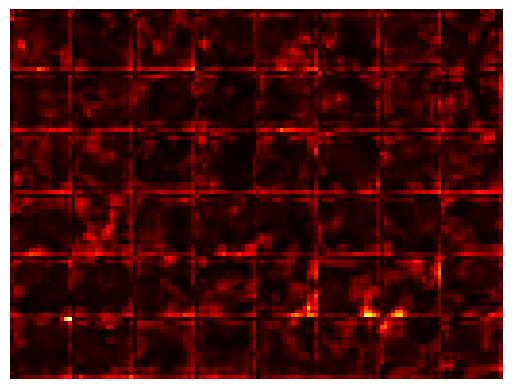

In [ ]:
# files.upload()
# arr = [2, 3, 6 ,7 ,9] #原本dataset的原圖編號
arr = [2]

target_image = Image.open("waldo_head.jpg")
print(f"target_image shape:{target_image.size}")

target_image = target_image.resize((32, 32))
print(f"target_image shape:{target_image.size}")

target_tensor = transform(target_image) #輸出(3,32,32)
print(f"target_tensor shape:{target_tensor.shape}")

min = target_tensor.min()
max = target_tensor.max()
print(f"min:{min}")
print(f"max:{max}")

target_features = model_target(target_tensor) #輸出(512,1,1)
print(f"target_features shape:{target_features.shape}")

for i in range(len(arr)):
  search_image = Image.open(f"{arr[i]}.jpg")
  print(f"search_image shape:{search_image.size}")

  search_image = resize_image(search_image)
  print(f"search_image shape:{search_image.size}")

  search_blocks = split_image(search_image)
  print(f"search_blocks shape:{len(search_blocks)}")

  search_tensor = process_blocks(search_blocks) #輸出(48,3,256,256)
  print(f"search_tensor shape:{search_tensor.shape}")

  search_features = model_search(search_tensor) #輸出(48,512,16,16)
  print(f"search_features shape:{search_features.shape}")

  attention_blocks = feature_matching(search_features, target_features) #輸出(48,1,16,16)
  print(f"attention_blocks shape:{attention_blocks.shape}")

  attention_map = generate_attention_map(attention_blocks) #輸出(96,128)
  print(f"attention_map shape:{attention_map.shape}")

  attention_map = np.transpose(attention_map, (1, 2, 0))

  plt.imshow(attention_map, cmap = "hot")
  plt.axis('off')
  plt.show()
